In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=0.0)
from ler.lens_galaxy_population import OpticalDepth

Setting multiprocessing start method to 'fork'


In [2]:
od_sis_gengamma = OpticalDepth(
    npool=8,
    z_min=0.0,
    z_max=10.0,
    lens_type="sis_galaxy",
    optical_depth_function="optical_depth_sis_analytic",
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_gengamma",  # zl dependent velocity dispersion
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min = 0., vd_max = 420., alpha = 2.32, beta = 2.67, phistar = 8.0e-3*cosmo.h**3, sigmastar = 161.0),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_json",
    verbose=True,
    create_new_interpolator=False,
)


Initializing OpticalDepth class

z_to_Dc interpolator will be loaded from ./interpolator_json/z_to_Dc/z_to_Dc_4.pickle
Dc_to_z interpolator will be loaded from ./interpolator_json/Dc_to_z/Dc_to_z_4.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_4.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_4.pickle
velocity_dispersion_gengamma interpolator will be loaded from ./interpolator_json/velocity_dispersion_gengamma/velocity_dispersion_gengamma_10.pickle
axis_ratio sampler: CPUDispatcher(<function OpticalDepth.axis_ratio_rayleigh.<locals>.<lambda> at 0x34717df30>) has been set.
Using pre-gererated optical depth function.
  funtion_name: optical_depth_sis_analytic.
  velocity_dispersion: velocity_dispersion_gengamma
Chosen velocity dispersion sampler: velocity_dispersion_gengamma
Chosen velocity dispersi

In [58]:
from ler.lens_galaxy_population import axis_ratio_rayleigh
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from gwsnr import cubic_spline_interpolator2d as csi2d
from ler.utils import append_json, save_json

In [22]:
size = 1000
q_arr = np.linspace(0.2, 1, size)
vd_arr = np.linspace(50, 420, size)

In [13]:
q_2D_arr = []
for i in range(size):
    q_samples = axis_ratio_rayleigh(vd_arr[i]*np.ones(size))
    q_pdf = gaussian_kde(q_samples)
    q_2D_arr.append(q_pdf(q_arr))

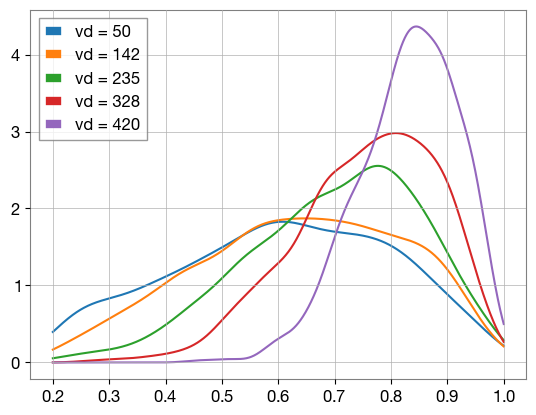

In [23]:
for sigma in np.linspace(50, 420, 5):
    q_samples = axis_ratio_rayleigh(sigma*np.ones(size))
    q_pdf = gaussian_kde(q_samples)
    plt.plot(q_arr, q_pdf(q_arr), label=f"vd = {sigma:.0f}")
    
plt.legend()
plt.show()

In [35]:
vd_size = 1000
vd_min = 50
vd_max = 420
vd_arr = np.linspace(vd_min, vd_max, vd_size)

q_size = 1000
q_min = 0.2
q_max = 1
q_arr = np.linspace(q_min, q_max, q_size)

pdf_coeff_ = []

for sigma in tqdm(
    vd_arr,
    total=vd_size,
    ncols=100,
):
    
    q_samples = axis_ratio_rayleigh(sigma*np.ones(q_size))
    q_pdf_fn = gaussian_kde(q_samples)
    q_pdf = q_pdf_fn.pdf(q_arr)
    
    pdf_coeff_.append(
        CubicSpline(
            q_arr,
            q_pdf,
        ).c
    )
pdf_coeff_ = np.array(pdf_coeff_)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


In [61]:
# /Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/mp.py
append_json("/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/axis_ratio_rayleigh.json", [q_arr, vd_arr, pdf_coeff_], replace=True)

[array([0.2      , 0.2008008, 0.2016016, ..., 0.9983984,
        0.9991992, 1.       ]),
 array([ 50.        ,  50.37037037,  50.74074074, ...,
        419.25925926, 419.62962963, 420.        ]),
 array([[[-2.56545933e+02, -2.56545933e+02, -2.57304000e+02,
          ..., -6.40452267e+01, -7.29374847e+01,
          -7.29374847e+01],
         [ 2.04598791e+01,  1.98435526e+01,  1.92272260e+01,
          ...,  4.26592156e+01,  4.25053532e+01,
           4.23301280e+01],
         [ 6.03931387e+00,  6.07158889e+00,  6.10287680e+00,
          ..., -3.93218495e+00, -3.86398510e+00,
          -3.79604878e+00],
         [ 3.04647576e-01,  3.09496852e-01,  3.14371579e-01,
          ...,  1.24183389e-01,  1.21061816e-01,
           1.17994754e-01]],
 
        [[-3.38169592e+02, -3.38169592e+02, -3.43395861e+02,
          ..., -5.48814717e+01, -5.89941173e+01,
          -5.89941173e+01],
         [ 1.97022327e+01,  1.88898133e+01,  1.80773939e+01,
          ...,  3.83983037e+01,  3.82664563e+01,
 

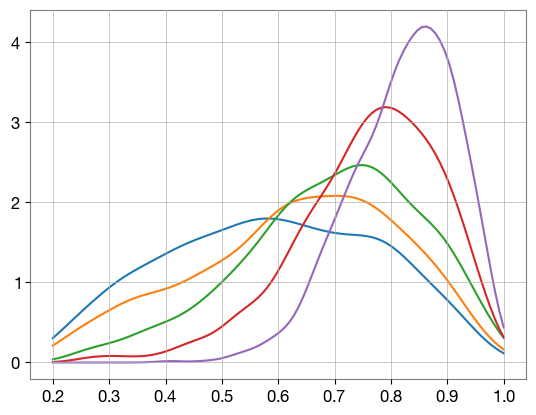

In [56]:
q_arr_new = np.linspace(q_min, q_max, 100)
vd_arr_new = np.linspace(vd_min, vd_max, 5)

for sigma in vd_arr_new:
    pdf_ = []
    for q in q_arr_new:
        pdf_.append(csi2d(q, sigma, pdf_coeff_, q_arr, vd_arr))
    plt.plot(q_arr_new, pdf_, label=f"vd = {sigma:.0f}")

In [54]:
csi2d(q_arr[0], vd_arr[0], pdf_coeff_, q_arr, vd_arr)

0.30464757551643706